# Meridional transects of mean planetary geostrophic potential vorticity, potential density anomaly and max/min monthly mean MLD

See [Kiss et al 2020](https://doi.org/10.5194/gmd-13-401-2020) Fig 15

In [1]:
# Parameters – this is the ONLY place you should edit
# when switching models / experiments / obs datasets.

### USER EDIT start

# ESM datastore (model output) – change this for a different run/model
# esm_file = "/g/data/zv30/non-cmip/ACCESS-CM3/cm3-run-11-08-2025-25km-beta-om3-new-um-params/cm3-demo-datastore/cm3-demo-datastore.json" #CM3 datastore

esm_file = "/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json"

# Frequency depends on the datastore you’re using:
data_frequency = "1mon"

# Optional special-case switches (e.g. 25 km quirks)
APPLY_OBS_25KM_Y_SLICE = False

# Plot settings
dpi = 300

### USER EDIT stop

import os
import sys
from matplotlib import rcParams

# Change working directory to the notebooks folder in the repo
project_root = f"/g/data/tm70/{os.environ['USER']}/access-om3-paper-1"
notebooks_dir = os.path.join(project_root, "notebooks")

# This makes CWD match where SST.ipynb and exptdata_access.py live
os.chdir(notebooks_dir)
print("Changed working directory to:", os.getcwd())

from exptdata_access import get_experiment_info, guess_experiment_from_esm_file
from model_agnostic import get_lon_lat_from_catalog, select_variable

%matplotlib inline
rcParams["figure.dpi"] = dpi

plotfolder = f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

# Infer model information from the datastore path
expt_key, info = guess_experiment_from_esm_file(esm_file)

model_name = info["model"]             # OM3 or CM3

print(f"Running notebook for model: {model_name}")
print("ESM datastore path:", esm_file)
print("Plot folder path:", plotfolder)

Changed working directory to: /g/data/tm70/ek4684/access-om3-paper-1/notebooks
Running notebook for model: ACCESS-OM3
ESM datastore path: /g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json
Plot folder path: /g/data/tm70/ek4684/access-om3-paper-figs/


In [2]:
import xarray as xr
import cf_xarray as cfxr
import intake
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
import cftime
import os
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from textwrap import wrap
from pathlib import Path

xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default

In [3]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


In [4]:
def prepare_model_window(
    da_model: xr.DataArray,
    datastore,
    *,
    exptname: str,
    averaging_mode: str = "last_n_years",   # "full_period" / "last_n_years" / "fixed_period"
    averaging_last_n_years: int = 10,
    averaging_start_date: str | None = None,
    averaging_end_date: str | None = None,
    region: dict | None = None,  # e.g. {"xt_ocean": -119.875, "yt_ocean": slice(-90, -15), "st_ocean": slice(None, 1700)}
):
    # --------------------------
    # helpers
    # --------------------------
    dim_alias = {
        "xt_ocean": ("xh", "xt_ocean", "lon", "longitude", "x"),
        "yt_ocean": ("yh", "yt_ocean", "lat", "latitude", "y"),
        "st_ocean": ("z_l", "zl", "st_ocean", "lev", "depth", "z"),
    }

    def _pick_dim(key: str, da: xr.DataArray):
        for d in dim_alias.get(key, (key,)):
            if d in da.dims:
                return d
        return None

    def _apply_region(da: xr.DataArray, region: dict):
        if not region:
            return da

        indexers = {}
        for user_dim, sel in region.items():
            d = _pick_dim(user_dim, da)
            if d is None:
                continue  # region asked for a dim this variable doesn't have

            # Exact point selection (e.g. xt_ocean=-119.875) → use nearest
            if not isinstance(sel, slice) and sel is not None:
                da = da.sel({d: sel}, method="nearest")
            else:
                indexers[d] = sel

        if indexers:
            da = da.sel(indexers)

        return da

    # --------------------------
    # 0) OM3 25km IAF grid quirk: yh not monotonic
    # --------------------------
    if exptname == "25km-iaf-test-for-AK-expt-7df5ef4c":
        if "yh" in da_model.dims:
            da_model = da_model.sortby("yh")

    # 1) Get lon/lat once from catalog
    lon, lat = get_lon_lat_from_catalog(datastore)

    # Apply the same sort to lon/lat if needed (keeps alignment)
    if exptname == "25km-iaf-test-for-AK-expt-7df5ef4c":
        if "yh" in lon.dims:
            lon = lon.sortby("yh")
        if "yh" in lat.dims:
            lat = lat.sortby("yh")

    # 2) Optional special-case y-slice (must hit data + coords consistently)
    if exptname == "25km-iaf-test-for-AK-expt-7df5ef4c":
        if "yh" in da_model.dims:
            da_model = da_model.isel(yh=slice(10, None))
            lon = lon.isel(yh=slice(10, None))
            lat = lat.isel(yh=slice(10, None))
        elif "yq" in da_model.dims:
            da_model = da_model.isel(yq=slice(10, None))
            lon = lon.isel(yq=slice(10, None))
            lat = lat.isel(yq=slice(10, None))

    # 3) Attach CF lon/lat if missing
    try:
        _ = da_model.cf["longitude"]
        _ = da_model.cf["latitude"]
        model_all = da_model
        print("Using existing CF longitude/latitude on da_model.")
    except KeyError:
        model_all = da_model.cf.assign_coords({"longitude": lon, "latitude": lat})
        print("Attached longitude/latitude from catalog grid variables.")

    # 4) Apply region restriction (works across xt_ocean/yt_ocean/st_ocean OR xh/yh/z_l etc.)
    model_all = _apply_region(model_all, region)
    print("model_all dims (after region):", model_all.dims)

    # 5) Calendar normalisation + time window
    if "time" in model_all.dims or "time" in model_all.coords:
        model_all = model_all.convert_calendar("proleptic_gregorian", use_cftime=True)

        t0 = model_all.time.values[0]
        t1 = model_all.time.values[-1]
        print("Full model time range:", t0, "→", t1)

        if averaging_mode == "full_period":
            datestart, datestop = t0, t1

        elif averaging_mode == "last_n_years":
            datestop = t1
            datelist = list(cftime.to_tuple(datestop))
            datelist[0] -= averaging_last_n_years
            datestart = cftime.datetime(*datelist, calendar=datestop.calendar)

        elif averaging_mode == "fixed_period":
            if averaging_start_date is None or averaging_end_date is None:
                raise ValueError("fixed_period requires averaging_start_date and averaging_end_date")
            datestart = xr.cftime_range(
                start=averaging_start_date, periods=1, calendar="proleptic_gregorian"
            )[0]
            datestop = xr.cftime_range(
                start=averaging_end_date, periods=1, calendar="proleptic_gregorian"
            )[0]
        else:
            raise ValueError(f"Unknown averaging_mode: {averaging_mode!r}")

        timerange = slice(datestart, datestop)
        print("Averaging window:", timerange)

        model_window = model_all.cf.sel(time=timerange)
        print("Windowed dims:", model_window.dims)
    else:
        print("No time axis found; skipping time-windowing.")
        model_window = model_all

    return model_all, model_window, lon, lat, datestart, datestop


In [5]:
def load_comparison_data(
    *,
    model_name: str,
    region: dict,
    om2_experiment: str,
    last_n_months: int = 120,
    cm2_potrho_file: str = "/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/ocn/",
    cm2_mld_file: str = "/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/ocn/",
):
    """
    Return a dict with reference datasets/fields, selecting:
      - OMIP2 (intake-esm) when model_name == ACCESS-OM3
      - CM2 postprocessed files when model_name == ACCESS-CM3
    """
    def _load_one(varname: str, last_n_months: int | None = None) -> xr.DataArray:
        if varname in ("geolon_t", "geolat_t"):
            dd = (
                ds_cat.search(variable=varname)
                .to_dataset_dict(
                    xarray_open_kwargs=dict(
                        decode_timedelta=True,
                        use_cftime=True,
                    ),
                    xarray_combine_by_coords_kwargs=dict(
                        compat="override",
                        coords="minimal",
                        data_vars="minimal",
                    ),
                    progressbar=False,
                )
            )
        else:
            dd = (
                ds_cat.search(variable=varname, frequency="1mon")
                .to_dataset_dict(
                    xarray_open_kwargs=dict(
                        chunks={"time": 1},   # NOT -1
                        decode_timedelta=True,
                        use_cftime=True,
                    ),
                    xarray_combine_by_coords_kwargs=dict(
                        compat="override",
                        coords="minimal",
                        data_vars="minimal",
                    ),
                    progressbar=False,
                )
            )
        key = sorted(dd.keys())[0]
        da = dd[key][varname]
        return da
    
    if model_name == "ACCESS-OM3":
        cat = intake.cat.access_nri
        ds_cat = cat[om2_experiment]

        # IMPORTANT: don't do ds_cat.to_dask() (it has multiple datasets)
        # Load only what we need via search + to_dataset_dict, then pick one.
        pot_rho_0 = _load_one("pot_rho_0", last_n_months=120)
        mld       = _load_one("mld",       last_n_months=120)
        geolat_t = _load_one("geolat_t")
        geolon_t = _load_one("geolon_t")
        ds_ref = xr.Dataset({"pot_rho_0": pot_rho_0, "mld": mld, "geolon_t": geolon_t, "geolat_t": geolat_t})
        ds_ref = ds_ref.assign_coords(
            geolon_t=geolon_t,
            geolat_t=geolat_t,)
        ds_ref = ds_ref.sel(**region)

        if "time" in ds_ref.dims:
            ds_ref = ds_ref.isel(time=slice(-last_n_months, None))

        ds_ref = ds_ref.compute()

        period_ref = (
            ds_ref.time[0].item().strftime("%Y-%m-%d"),
            ds_ref.time[-1].item().strftime("%Y-%m-%d"),
        )

        return dict(
            ref_label=f"OMIP2 ({om2_experiment})",
            ds_ref=ds_ref,
            period_ref=period_ref,
            potrho0_plot_ref=ds_ref["pot_rho_0"].mean("time"),
            mldmin_ref=ds_ref["mld"].min("time"),
            mldmax_ref=ds_ref["mld"].max("time"),
            pPV_plot_ref=(ds_ref["pPV"].mean("time") if "pPV" in ds_ref else None),
        )


    elif model_name == "ACCESS-CM3":
        cm2_dir = Path("/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/ocn")
        last_n_months = 120
    
        # ---- pot_rho_0 (3D monthly) ----
        rho_files_all = sorted(cm2_dir.glob("ocean-3d-pot_rho_0-1-monthly-mean-ym_*.nc"))
        rho_files = rho_files_all[-last_n_months:]

        if not rho_files:
            raise FileNotFoundError("No pot_rho_0 monthly files found")
    
        ds_rho = xr.open_mfdataset(
            rho_files,
            combine="by_coords",
            parallel=True,
            chunks={"time": 12},
            decode_timedelta=True,
            use_cftime=True,
        )
    
        potrho0 = ds_rho["pot_rho_0"].isel(time=slice(-last_n_months, None)).sel(**region)
    
        # ---- mld (2D monthly) ----
        mld_files = sorted(cm2_dir.glob("ocean-2d-mld-1-monthly-mean-ym_*.nc"))
        if not mld_files:
            raise FileNotFoundError("No mld monthly files found")
    
        ds_mld = xr.open_mfdataset(
            mld_files,
            combine="by_coords",
            parallel=True,
            chunks={"time": 12},
            decode_timedelta=True,
            use_cftime=True,
        )
    
        mld = (
            ds_mld["mld"]
            .isel(time=slice(-last_n_months, None))
            .sel(xt_ocean=-119.875)
            .sel(yt_ocean=slice(-90, -15))
        )    
        ds_ref = xr.Dataset({"pot_rho_0": potrho0, "mld": mld}).convert_calendar("proleptic_gregorian", use_cftime=True)
        period_ref = (
            str(potrho0.time.values[0]),
            str(potrho0.time.values[-1]),
        )
    
        return dict(
            ref_label="CM2 (cj877 archive, last 120 months)",
            ds_ref=ds_ref,
            period_ref=period_ref,
            potrho0_plot_ref=potrho0.mean("time"),
            mldmin_ref=mld.min("time"),
            mldmax_ref=mld.max("time"),
            pPV_plot_ref=None,
        )
    else:
        raise ValueError(f"Unknown model_name: {model_name!r}")

# ACCESS OM3 or CM3

### Open the intake-esm datastore

In [6]:
exptname=os.path.basename(os.path.dirname(esm_file))
print("Experiment name:", exptname)

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

Experiment name: MC_25km_jra_iaf-1.0-beta-5165c0f8


### Open required variables

**TODO**: Should be using `rhopot0`, but this is not currently saved

In [7]:
# --- Potential density (rho_pot_0) ---
rho = select_variable(
    datastore,
    variable_standard_name="Potential density referenced to surface",
    fallback_variable_names=["rhopot0", "rhopot2"],
    data_frequency=data_frequency,
)

print("Selected rho variable:", rho.name)
print("rho dims:", rho.dims)


# --- Mixed Layer Depth ---
mld = select_variable(
    datastore,
    variable_standard_name="Ocean Mixed Layer Thickness Defined by Sigma T",
    fallback_variable_names=[
        "mlotst",
        "mld",
        "mixed_layer_depth",
        "mixed_layer_thickness",
    ],
    data_frequency=data_frequency,
)
print("Selected MLD variable:", mld.name)
print("MLD dims:", mld.dims)

CF-based lookup failed: ValueError('No entries found for this CF standard_name.')


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Selected variable via fallback name: rhopot0
Selected rho variable: rhopot0
rho dims: ('time', 'z_l', 'yh', 'xh')
CF-based lookup failed: ValueError('No entries found for this CF standard_name.')


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Selected variable via fallback name: mlotst
Selected MLD variable: mlotst
MLD dims: ('time', 'yh', 'xh')


In [8]:
averaging_mode = "last_n_years"   # or "full_period" / "fixed_period"
averaging_last_n_years = 10
averaging_start_date = None
averaging_end_date   = None

### Only keep last 10 years of data in the region of interest

In [9]:
region = {
    "xt_ocean": -119.875,
    "yt_ocean": slice(-90, -15),
    "st_ocean": slice(None, 1700),
}

rho_all, rho_window, lon, lat, datestart, datestop = prepare_model_window(
    rho, datastore,
    exptname=exptname,
    averaging_mode=averaging_mode,
    averaging_last_n_years=averaging_last_n_years,
    averaging_start_date=averaging_start_date,
    averaging_end_date=averaging_end_date,
    region=region,
)

mld_all, mld_window, lon, lat, datestart, datestop = prepare_model_window(
    mld, datastore,
    exptname=exptname,
    averaging_mode=averaging_mode,
    averaging_last_n_years=averaging_last_n_years,
    averaging_start_date=averaging_start_date,
    averaging_end_date=averaging_end_date,
    region=region,
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Using existing CF longitude/latitude on da_model.
model_all dims (after region): ('time', 'z_l', 'yh')
Full model time range: 1958-01-16 12:00:00 → 2014-12-16 12:00:00
Averaging window: slice(cftime.datetime(2004, 12, 16, 12, 0, 0, 0, calendar='proleptic_gregorian', has_year_zero=True), cftime.DatetimeProlepticGregorian(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True), None)
Windowed dims: ('time', 'z_l', 'yh')


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Using existing CF longitude/latitude on da_model.
model_all dims (after region): ('time', 'yh')
Full model time range: 1958-01-16 12:00:00 → 2014-12-16 12:00:00
Averaging window: slice(cftime.datetime(2004, 12, 16, 12, 0, 0, 0, calendar='proleptic_gregorian', has_year_zero=True), cftime.DatetimeProlepticGregorian(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True), None)
Windowed dims: ('time', 'yh')


### Calculate the planetary potential vorticity
Constants below are as used in MOM6 by default

**TODO**: Should we use saved `Coriolis` diagnostic here? It's on q-points so would have to be interpolated.

In [10]:
lat = rho_window.coords.get("geolat", rho["yh"])

In [11]:
g = 9.80
rho0  = 1040.0
omega  = 7.2921e-5
coriolis = 2.0 * omega * np.sin(np.deg2rad(lat))

dpotrho2dz_om3 = rho_window.differentiate(coord="z_l")

pPV_om3 = -coriolis * g / rho0 * dpotrho2dz_om3

In [12]:
pPV_om3_w = pPV_om3.sortby("time").isel(time=slice(-120, None))
pPV_om3_w = pPV_om3_w.chunk({"time": 1})
pPV_plot_om3 = pPV_om3_w.mean("time").compute()

In [13]:
pPV_plot_om3 = pPV_om3.mean("time").compute()
potrho2_plot_om3 = rho_window.mean("time").compute()
mldmin_om3 = mld_window.min("time").compute()
mldmax_om3 = mld_window.max("time").compute()

# Open the intake-esm datastore

### Only keep last 10 years of data in the region of interest

In [14]:
if model_name == "ACCESS-OM3":
    experiment = "025deg_jra55_iaf_omip2_cycle6"
elif model_name == "ACCESS-CM3":
    experiment = "cj877"
    
ref = load_comparison_data(
    model_name=model_name,
    region=region,
    om2_experiment=experiment,
    last_n_months=120,
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:101: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:101: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:101: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(u

### Calculate the planetary potential vorticity

Constants below are as used in MOM5 by default

In [15]:
g = 9.80
rho0  = 1035.0
omega  = 7.292e-5
#lat = ref["ds_ref"]["geolat_t"] 
lat = ref["ds_ref"]["yt_ocean"] 
coriolis = 2.0 * omega * np.sin(np.deg2rad(lat))

dpotrho0dz_om2 = ref["ds_ref"]["pot_rho_0"].differentiate(coord="st_ocean")

pPV_om2 = -coriolis * g / rho0 * dpotrho0dz_om2

# Plot

### Compute OM2 quantities

In [16]:
pPV_plot_om2 = pPV_om2.mean("time")
potrho0_plot_om2 = ref["ds_ref"]["pot_rho_0"].mean("time")
mldmin_om2 = ref["ds_ref"]["mld"].min("time")
mldmax_om2 = ref["ds_ref"]["mld"].max("time")

### Create plot

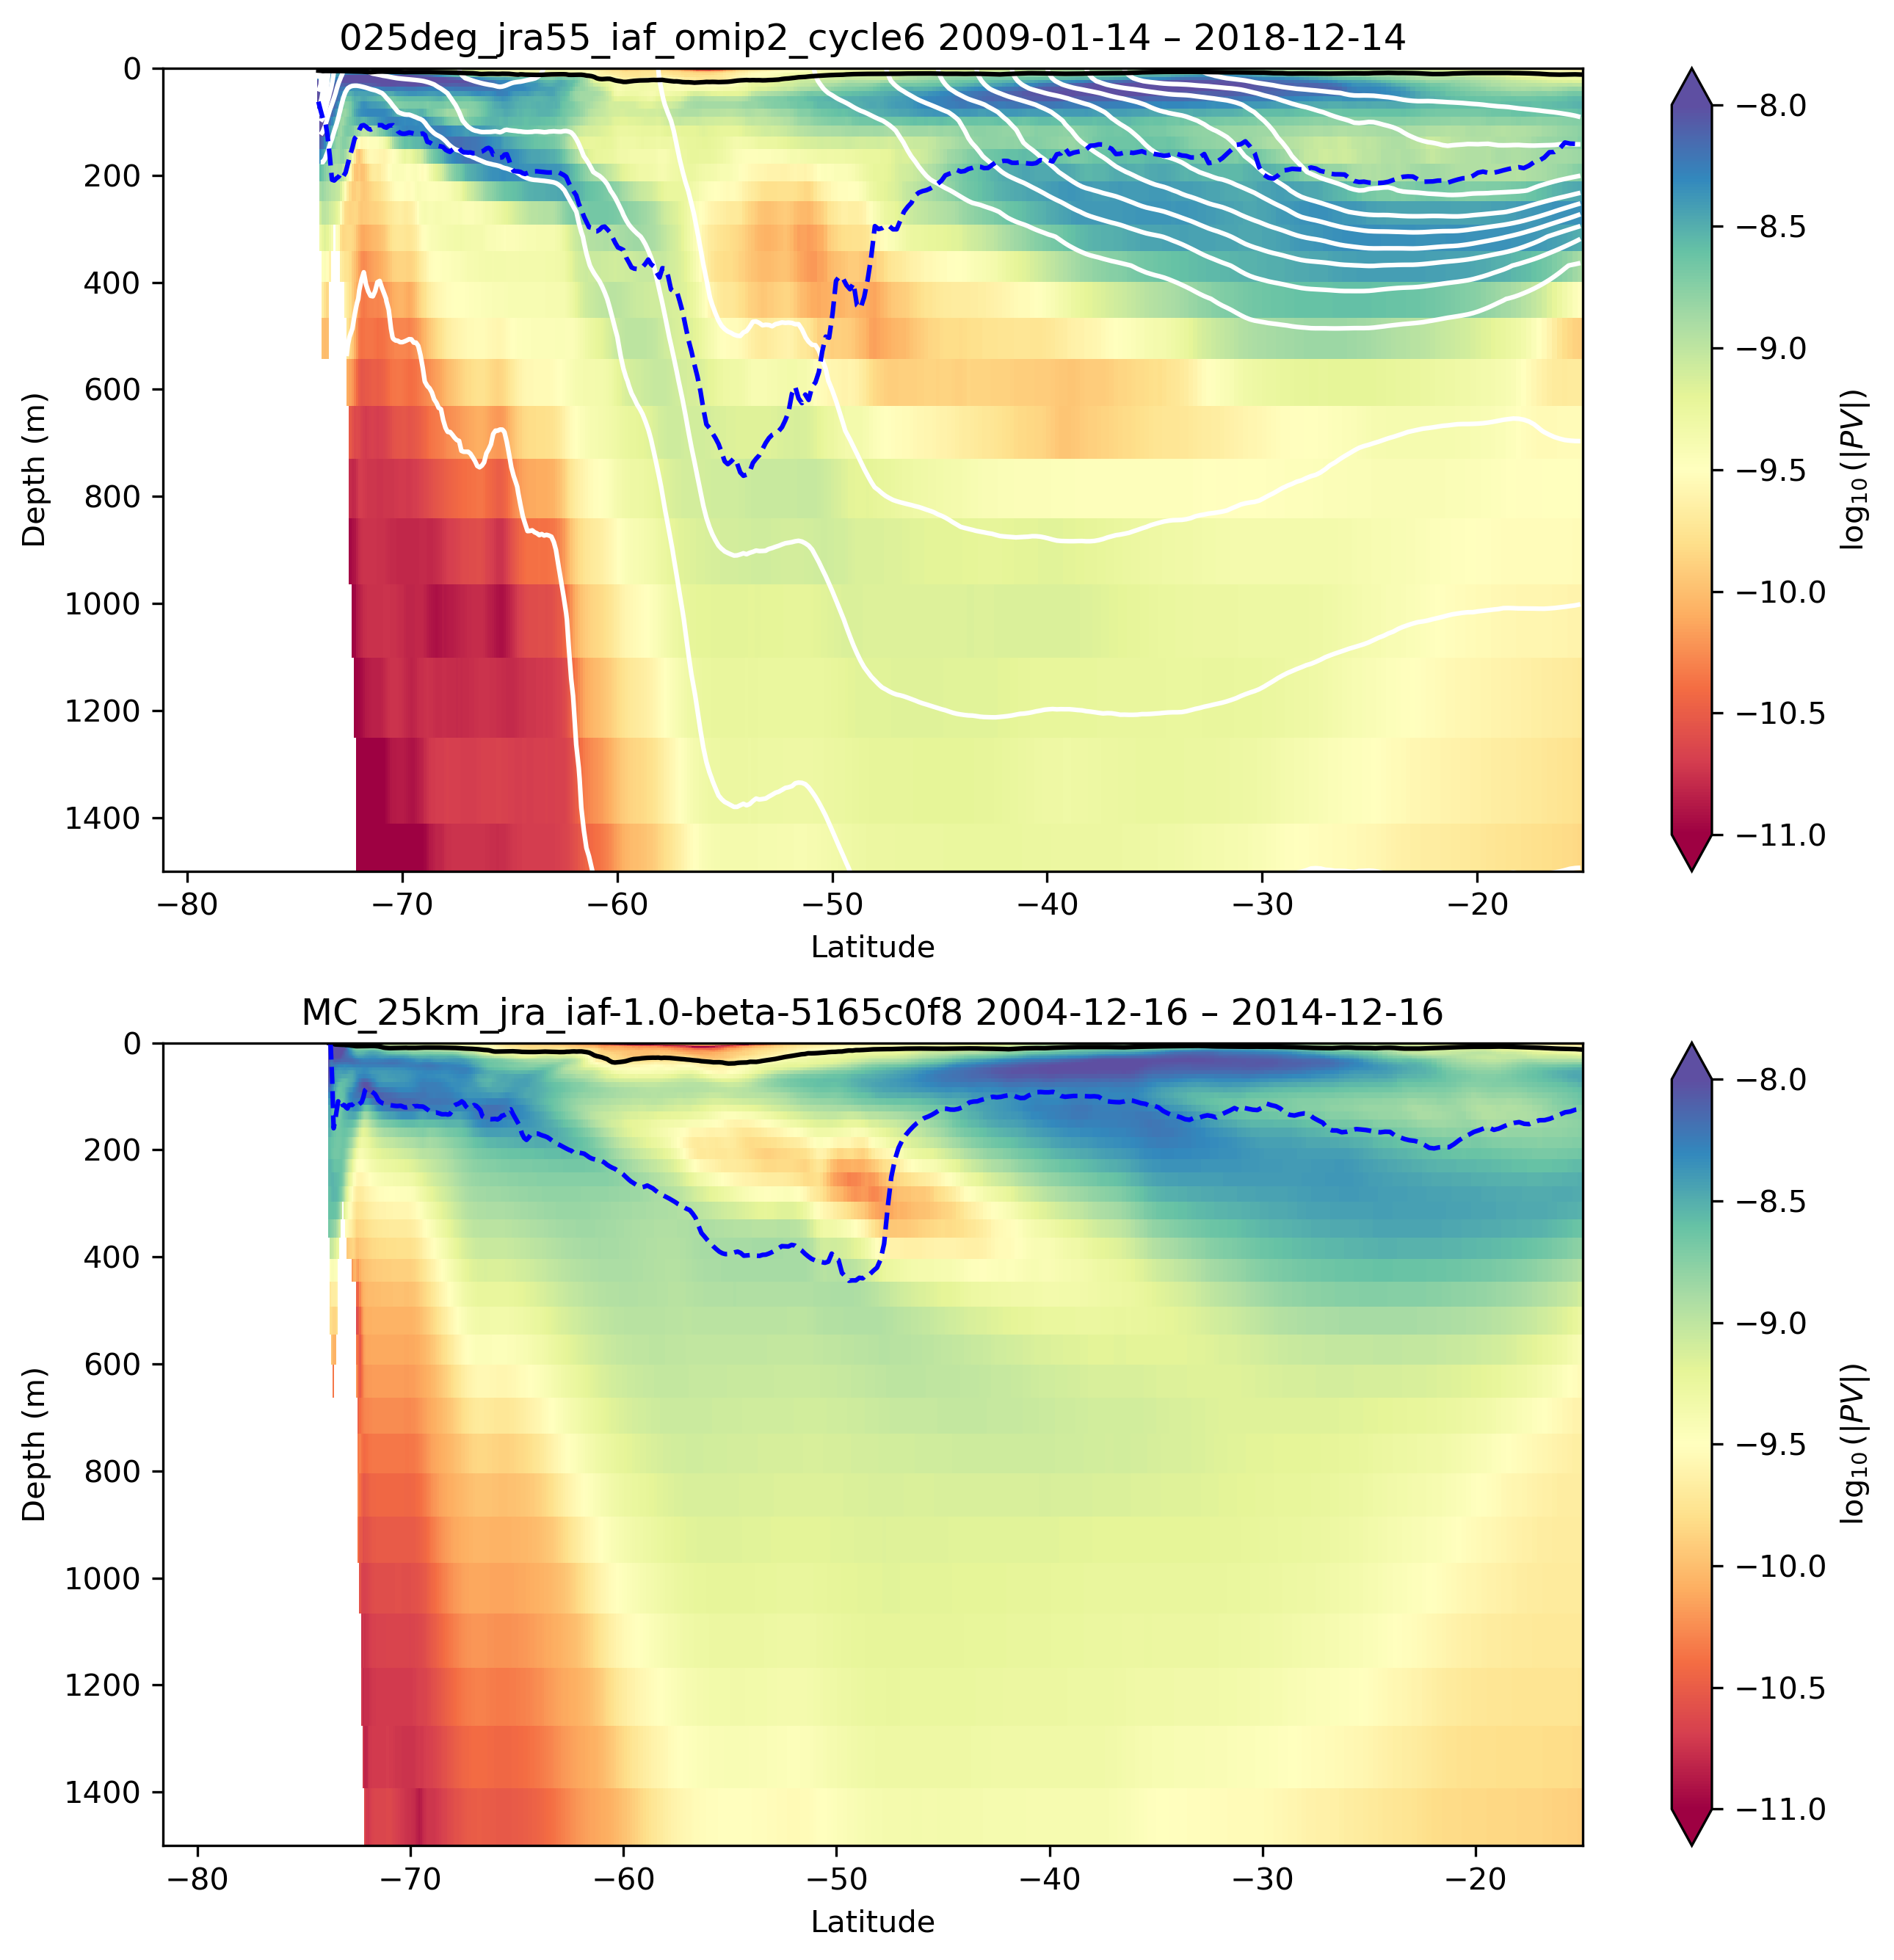

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(9, 9))

# ACCESS-OM2
xr.ufuncs.log10(abs(pPV_plot_om2)).plot(
    ax=axs[0],
    x="yt_ocean",
    cmap="Spectral",
    vmin=-11,
    vmax=-8,
    cbar_kwargs={"label": "$\log_{10}(|PV|)$"},
)
potrho0_plot_om2.plot.contour(
    ax=axs[0],
    levels=np.arange(1024.75, 1030, 0.25),
    colors="w"
)
mldmin_om2.plot(ax=axs[0], color="k")
mldmax_om2.plot(ax=axs[0], color="b", linestyle="--")

axs[0].set_ylim(1500, 0)
axs[0].set_xlabel("Latitude")
axs[0].set_ylabel("Depth (m)")
axs[0].set_title(f"{experiment} "
                f"{ref['period_ref'][0]} – {ref['period_ref'][1]}")

# ACCESS-OM3
xr.ufuncs.log10(abs(pPV_plot_om3)).plot(
    ax=axs[1],
    x="yh",
    cmap="Spectral",
    vmin=-11,
    vmax=-8,
    cbar_kwargs={"label": "$\log_{10}(|PV|)$"},
)
potrho2_plot_om3.plot.contour(
    ax=axs[1],
    levels=np.arange(1024.75, 1030, 0.25)+8,
    colors="w"
)
mldmin_om3.plot(ax=axs[1], color="k")
mldmax_om3.plot(ax=axs[1], color="b", linestyle="--")

axs[1].set_ylim(1500, 0)
axs[1].set_xlabel("Latitude")
axs[1].set_ylabel("Depth (m)")
axs[1].set_title(f"{exptname} " 
                f"{datestart.strftime('%Y-%m-%d')} – {datestop.strftime('%Y-%m-%d')}")

plt.tight_layout()

In [ ]:
client.close()